In [1]:
import copy
from pathlib import Path
import nmslib
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from scipy import spatial

import sys
sys.path.append('../')

from src.deepfashion.dataset import DeepFashionDataset, Split
from src.helpers import create_index, get_nearest_neighbors, cos_dist, get_nearest_neighbors_batch

## Create NMSLIB index for efficient k-NN search

In [2]:
model_name = 'normal-24-epochs'
root_dir = '../data/DeepFashion/'
fashion_dataset = DeepFashionDataset(root_dir=root_dir, split=Split.TEST)
inital_index, article_embeddings = create_index(root_dir, model_name)

len(article_embeddings)

106649

## Add adversarial examples

In [3]:
epsilon = "0.01"
adv_embeddings = article_embeddings.copy()

adv_path = f'../results/attack/{model_name}/cw/{epsilon}/adversarial_examples.tsv'
print(adv_path)
adv_embedding = pd.read_csv(adv_path, sep='\t').set_index('image')
adv_embeddings = adv_embeddings.append(adv_embedding)

adv_path = f'../results/attack/{model_name}/fgsm/{epsilon}/adversarial_examples.tsv'
adv_embedding = pd.read_csv(adv_path, sep='\t').set_index('image')
adv_embeddings = adv_embeddings.append(adv_embedding)

adv_path = f'../results/attack/{model_name}/pgd/{epsilon}/adversarial_examples.tsv'
adv_embedding = pd.read_csv(adv_path, sep='\t').set_index('image')
adv_embeddings = adv_embeddings.append(adv_embedding)

len(adv_embeddings)

../results/attack/normal-24-epochs/cw/0.01/adversarial_examples.tsv


106652

In [4]:
adv_index = nmslib.init(method='hnsw', space='cosinesimil')
adv_index.addDataPointBatch(adv_embeddings.values)
adv_index.createIndex({'post': 2}, print_progress=True)

## Query k-NN index

In [5]:
def visualize_knn_reco(inital_index, adv_index, query_article, k=5):
    print(query_article.name)
    print(article_embeddings.index.get_loc(query_article.name))
    query_vec = query_article.values
    
    initial_ids, initial_distances = inital_index.knnQuery(query_vec, 100_000+1)
    initial_ids, initial_distances = initial_ids, initial_distances
    
    adv_ids, adv_distances = adv_index.knnQuery(query_vec, 100_000+1)
    adv_ids, adv_distances = adv_ids, adv_distances
    
    ids = zip(initial_ids[1:], adv_ids[1:])
    distances = zip(initial_distances[1:], adv_distances[1:])
    
    query_image_file = query_article.name
    query_image = Image.open('../data/DeepFashion/' + query_image_file)
    plt.imshow(query_image)
    plt.title('Query image')
    plt.show()
    
    for i, d in zip(ids, distances):
        fig, axes = plt.subplots(1, 2)
        
        initial_image_file = article_embeddings.iloc[i[0]].name
        print(article_embeddings.iloc[i[0]].name, d[0])

        initial_image = Image.open('../data/DeepFashion/' + initial_image_file)
        axes[0].imshow(initial_image)
        axes[0].set_title(f'Cosine distance = {d[0]:.4f}')
        
        adv_image_file = adv_embeddings.iloc[i[1]].name
        print(adv_embeddings.iloc[i[1]].name, d[1])

        adv_image = Image.open('../data/DeepFashion/' + adv_image_file)
        axes[1].imshow(adv_image)
        axes[1].set_title(f'Cosine distance = {d[1]:.4f}')
        
        plt.show()

In [18]:
visualize_knn_reco(inital_index, adv_index, article_embeddings.loc['img_resized/Striped_Textured_Sweater/img_00000024.jpg'], k=5)

img_resized/Striped_Textured_Sweater/img_00000024.jpg


AttributeError: 'DataFrame' object has no attribute 'get_loc'

In [74]:
top_10_distances = []
for idx, row in article_embeddings.iterrows():
    top_10_distances.append(get_nearest_neighbors(inital_index, row, 10)[1])
top_10_distances = np.array(top_10_distances)

In [75]:
rank = 2

In [76]:
np.mean(top_10_distances[:,rank])

0.06579617

In [77]:
np.median(top_10_distances[:,rank])

0.05973959

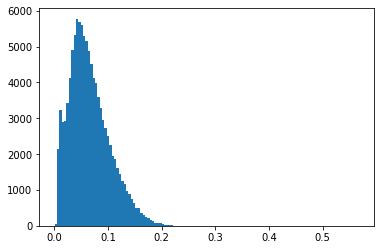

In [78]:
#import tikzplotlib
plt.hist(top_10_distances[:,rank], bins=128)
plt.show()
#tikzplotlib.save(f'../results/figures/k5_distances_{model_name}.tex')

In [80]:
np.percentile(top_10_distances[:,rank], 10)

0.02192186117172241